In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scipy

import networkx as nx

In [3]:
from decipher_model import DecipherConfig, Decipher
from load_data import palette_original
from post_analysis import rotate_decipher_space, cluster_representations, compute_trajectories, compute_decipher_time
from post_analysis_plotting import plot_decipher_v, plot_trajectory, plot_gene_patterns, add_cell_type_band

In [4]:
adata = sc.read_h5ad("data/AML1.decipher.h5ad")
n_genes = adata.shape[1]

cvi_config = DecipherConfig(
    seed=0,
    learning_rate=1e-3,
)
model = Decipher(
    genes_dim=n_genes,
    decipher_config=cvi_config,
)
model.load_state_dict(torch.load("data/AML1.decipher.pth"))
model.eval();


# compatibility - to do in original adata
adata.obsm["decipher_v"] = adata.obsm["latent_p"]
adata.obsm["decipher_z"] = adata.obsm["latent_z"]
adata.obs["origin"] = adata.obs["origin"].replace({"p89":"AML1", "healthy": "Healthy"})

V4


In [5]:
import scvi

In [8]:
scvi.data.setup_anndata(
    adata,
    batch_key="origin"
)

INFO     Using batches from adata.obs["origin"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18000 cells, 3130 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [14]:
model = scvi.model.SCVI(adata)

In [15]:
model.train(100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 100/100: 100%|██████████| 100/100 [14:19<00:00,  8.59s/it, loss=3.22e+03, v_num=1]


In [16]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent




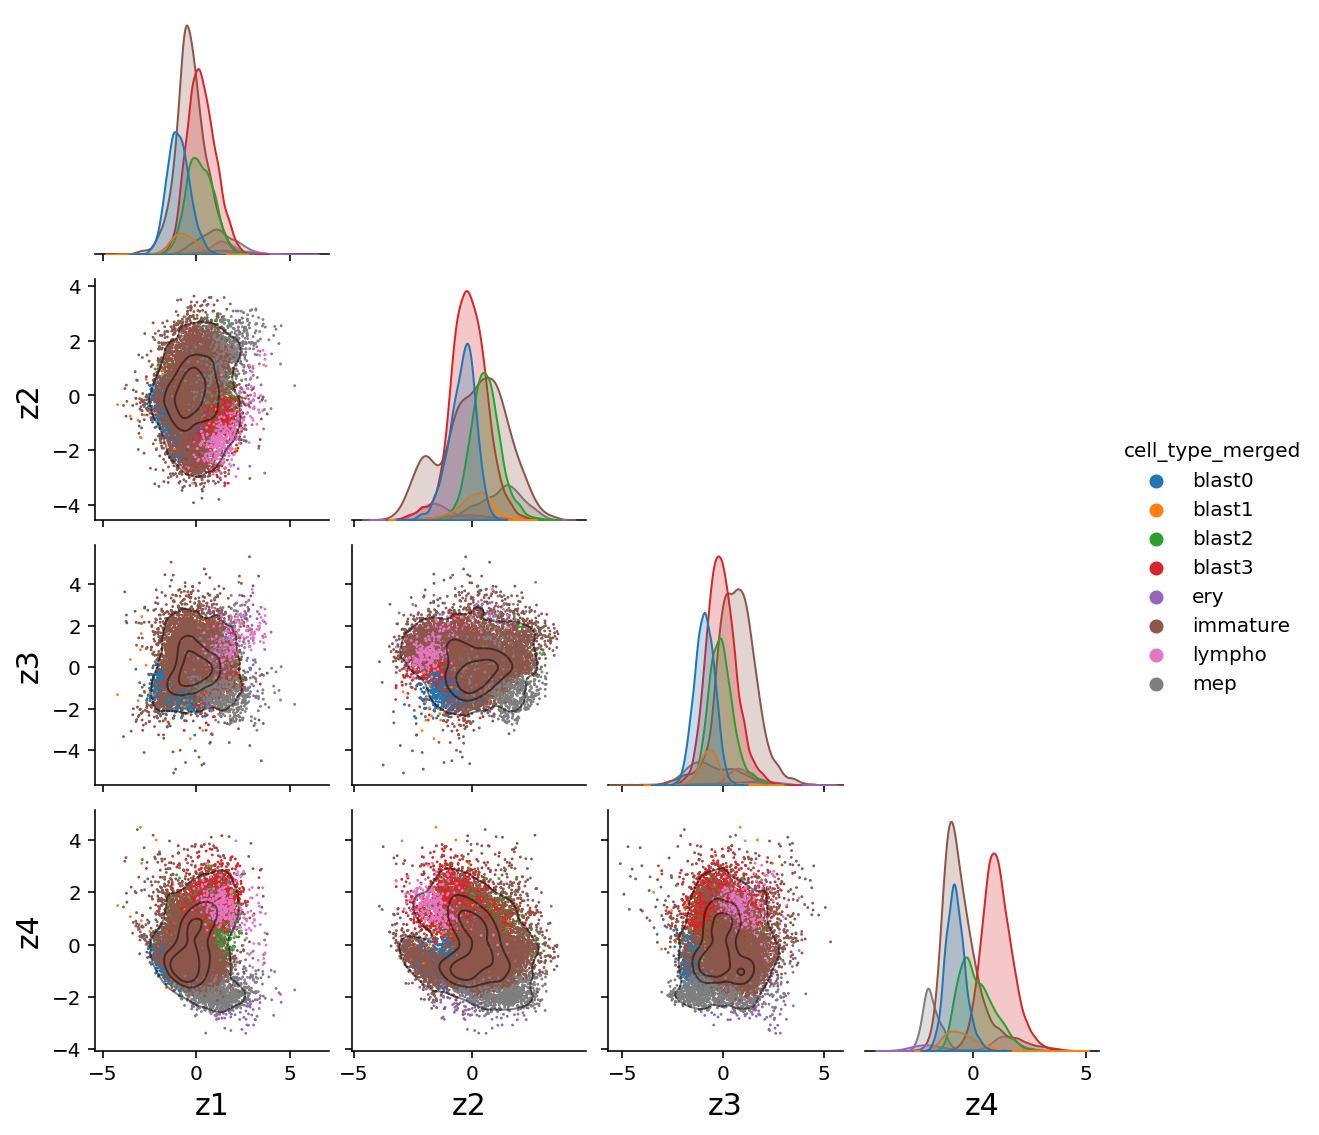

In [46]:
def f(hue,*args, **kwargs):
    sns.kdeplot(**kwargs)

tmp_data = pd.DataFrame(adata.obsm['X_scVI'], columns=["z%d" % (i+1) for i in range(10)])
tmp_data["origin"] = adata.obs["origin"].values
tmp_data["cell_type_merged"] = adata.obs["cell_type_merged"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):
    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1", "z2", "z3", "z4"],
        y_vars=["z1", "z2", "z3", "z4"],
        corner=True,
        hue="cell_type_merged",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
    
plt.savefig("figures/figure2/AML1.corner_plot.scvi.pdf", bbox_inches="tight", dpi=1200)

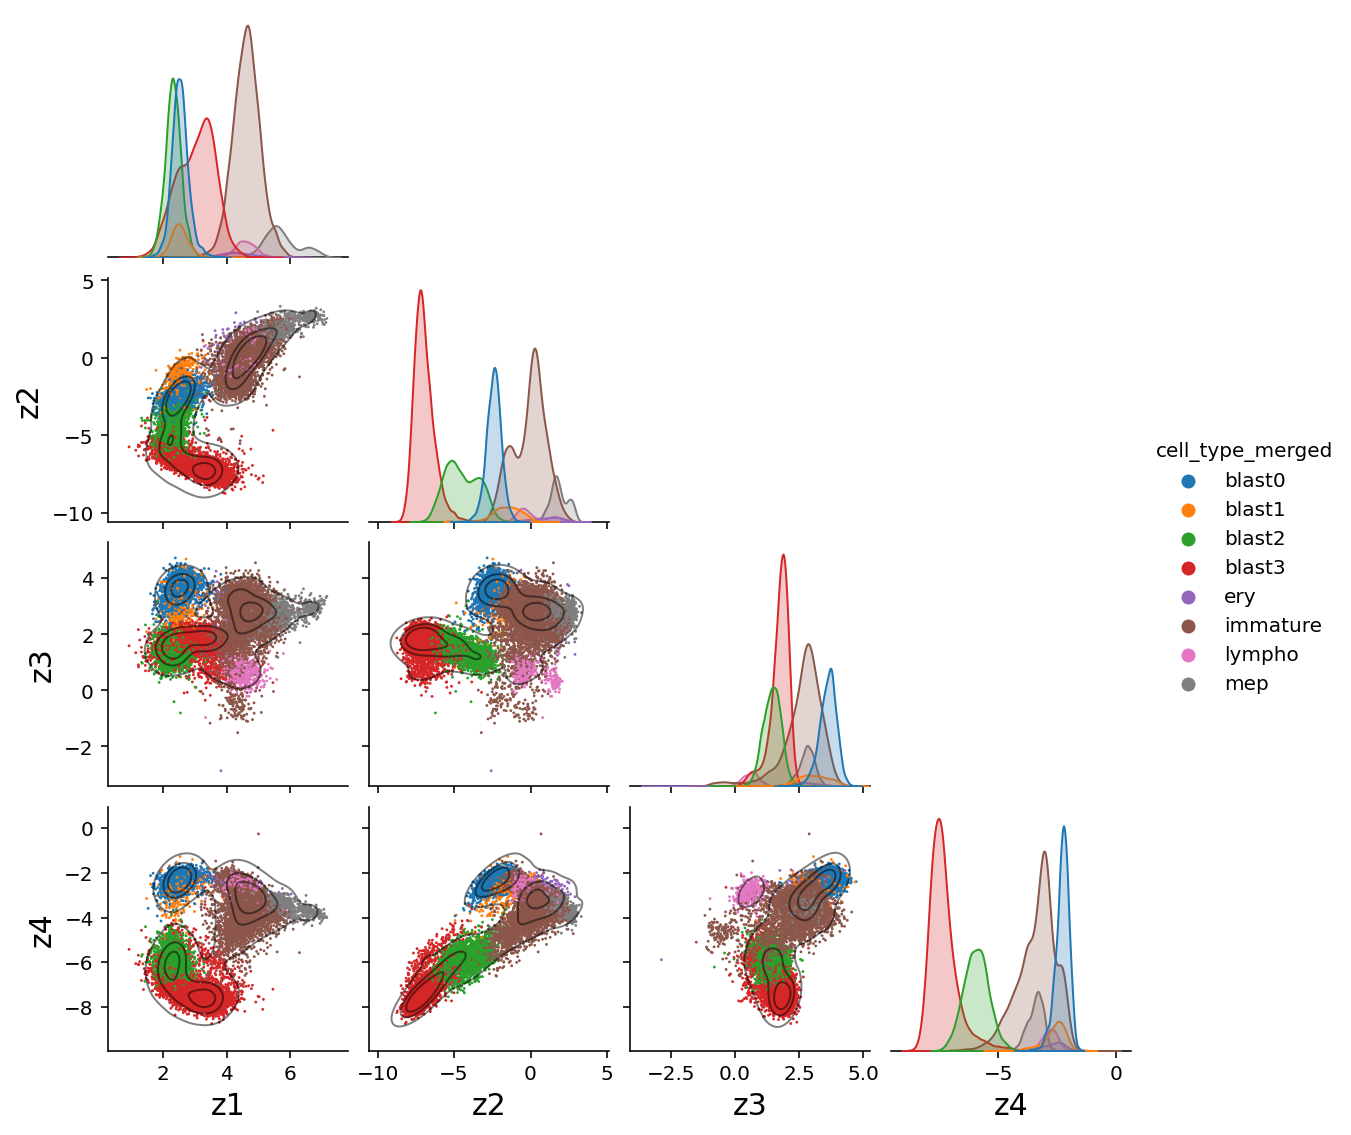

In [51]:
def f(hue,*args, **kwargs):
    sns.kdeplot(**kwargs)

tmp_data = pd.DataFrame(adata.obsm['decipher_z'], columns=["z%d" % (i+1) for i in range(10)])
tmp_data["origin"] = adata.obs["origin"].values
tmp_data["cell_type_merged"] = adata.obs["cell_type_merged"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1", "z2", "z3", "z4"],
        y_vars=["z1", "z2", "z3", "z4"],
        corner=True,
        hue="cell_type_merged",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
    
plt.savefig("figures/figure2/AML1.corner_plot.decipher.pdf", bbox_inches="tight",  dpi=1200)

In [48]:
adata.obs["origin_int"] = adata.obs["origin"].replace({"AML1": 1, "Healthy": 0})
rotate_decipher_space(
    adata, "origin_int", decipher_component_to_align_label_with=2, flip_latent_z=True
)

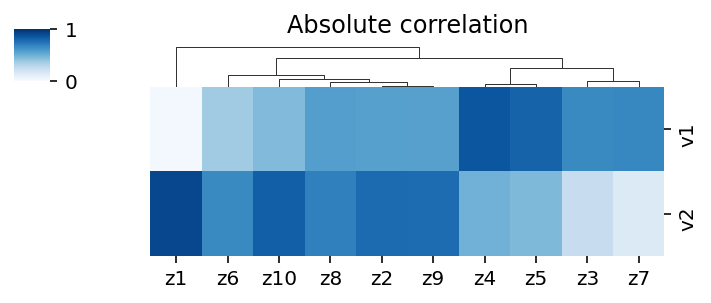

In [49]:
tmp = pd.DataFrame(
    np.hstack((adata.obsm["decipher_v_corrected"], adata.obsm["decipher_z_corrected"])),
    columns=["v1", "v2"] + ["z%d" % (i+1) for i in range(10)]
)

cg = sns.clustermap(
    tmp.corr().iloc[:2, 2:].abs(), figsize=(5, 2), cmap="Blues", vmin=0, vmax=1, row_cluster=False
)
cg.figure.axes[1].set_title("Absolute correlation")
# plt.tight_layout()
plt.savefig("figures/figure2/AML1.v_z_correlation.pdf", bbox_inches="tight")